In [2]:
using ChaosTools
using DynamicalSystems
using PyPlot
using OrdinaryDiffEq, LinearAlgebra, ForwardDiff, PyPlot
using Distributions

In [18]:
PyPlot.pygui(false)

false

In [17]:

x = rand(Truncated(Normal(0, 1.), -1., 1.), 100)
x=x.-8
y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
grid=Iterators.product(x,y)
grid=collect.(grid)
println(grid[1])
println(grid[1][1])
#pre(grid[1][1],grid[1][2],m[1],m[2],a,b,Hinicial)

[-7.9290635955293345, -0.9500053627600282]
-7.9290635955293345


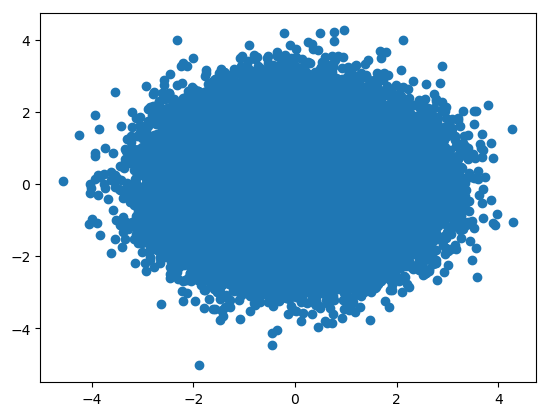

  0.000577 seconds (6 allocations: 781.484 KiB)
  0.000657 seconds (6 allocations: 781.484 KiB)
  0.006668 seconds (23 allocations: 3.052 MiB)
  0.004689 seconds (23 allocations: 3.052 MiB)


100000-element Array{Float64,1}:
 1.8968990257834872
 2.027918492267011 
 2.0624330796453783
 1.859603946495804 
 1.9679155305001985
 1.8772571595702503
 2.1507742313345894
 1.9813085131962804
 2.085519065868417 
 1.995768979760476 
 2.0673641207446836
 1.9098527427836167
 2.0414521329441566
 ⋮                 
 1.94446642933887  
 2.0706989288863134
 1.9626186898837656
 1.9891385094169889
 2.2489851698432606
 2.2370976374205425
 2.0322401084688453
 2.1407310361020144
 2.1088535806842152
 1.915044876997056 
 1.8434842168238932
 2.0700087098103537

In [76]:
arraysize=100000
@time u1 = rand(arraysize)
@time u2 = rand(arraysize)
@time z0 = map.(sqrt,-2* map.(log,u1)) .*map.(cos,2. *pi*u2)
@time z1 = map.(sqrt,-2* map.(log,u1)) .*map.(sin,2. *pi*u2)
scatter(z0,z1)

xz0=z0*0.15
pz1=z1*0.1
Xz0=z0 .+20.
Pz1=z1*0.1 .+2.

#x=x.-8
#y=rand(Truncated(Normal(0, 1.), -1.5, 1.5), 100)
#grid=Iterators.product(x,y)
#grid=collect.(grid)
#println(grid[1])
#println(grid[1][1])

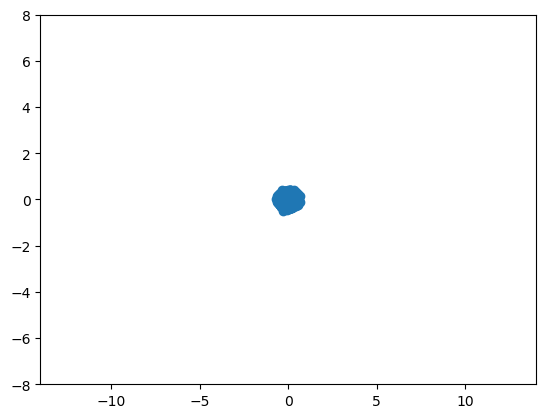

(-14, 14)

In [79]:
scatter(xz0,pz1)
ylim(-8,8)
xlim(-14,14)


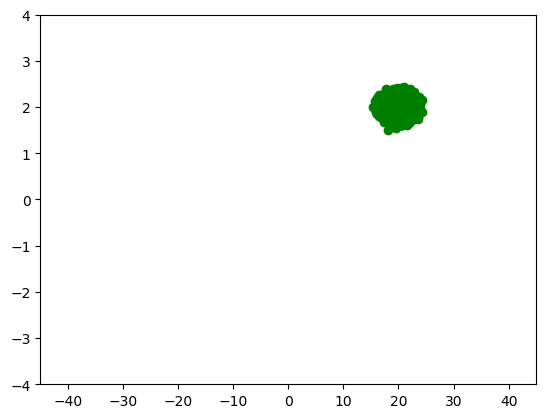

(-45, 45)

In [80]:
scatter(Xz0,Pz1,color="g")
ylim(-4,4)
xlim(-45,45)

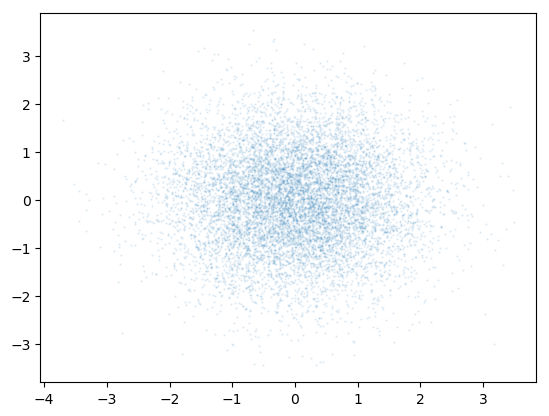

  0.059197 seconds (95 allocations: 3.625 KiB)


PyObject <matplotlib.collections.PathCollection object at 0x7fb603508668>

In [50]:
@time scatter(z0,z1,alpha=0.1,s=0.5)

In [74]:
initial_position = [0.1, 0.]
initial_momentum=[0. ,0.1]

2-element Array{Float64,1}:
 0.0
 0.1

In [21]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:10000
    #println(jj)
    Hinicial=15.0
    initial_position[1]=grid[jj][1]
    initial_momentum[1]=grid[jj][2]
    
    initial_momentum[2]=energia_poinc_abs(initial_position[1],initial_momentum[1],m[1],m[2],a,b,Hinicial) #osciladores
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.5)
        ylim(-6,6)
        xlim(-11,11)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.5)
        ylim(-2.5,2.5)
        xlim(-35,35)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)

BoundsError: BoundsError: attempt to access 70×70 Array{Array{Float64,1},2} at index [4901]

In [20]:
lim=1000
plot(entsys[1:400],label="system information")
plot(entpozo[1:400],label="particle information")
plot(entosci[1:400],label="oscillator information")
plot(entmutua[1:400],label="mutual information")
legend()
xlabel("time steps / 10")
ylabel("Shannon Information")
title("Mutual Information")
savefig("mutualinfo.png")
clf()

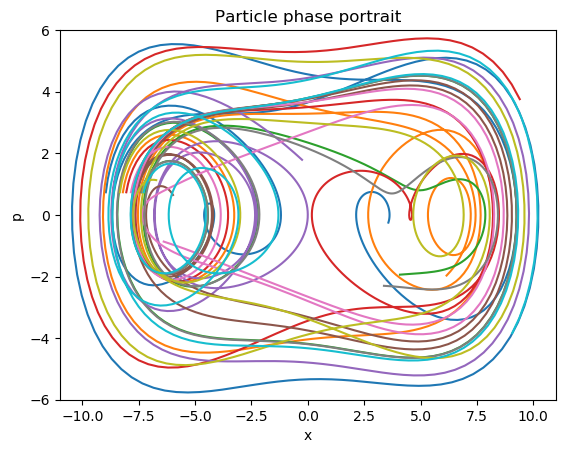

In [68]:
plot(Q1[1:400,1:10],P1[1:400,1:10])
title("Particle phase portrait")
xlabel("x")
ylabel("p")
ylim(-6,6)
xlim(-11,11)
savefig("mutualinfo_phase.png")
clf()

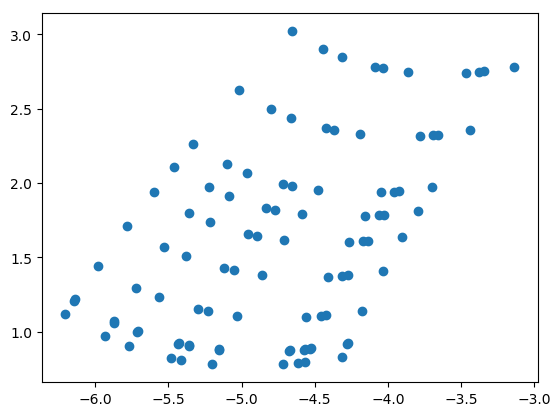

PyObject <matplotlib.collections.PathCollection object at 0x7f66095d7c50>

In [36]:
PyPlot.scatter(bbb[:,1],bbb[:,2])


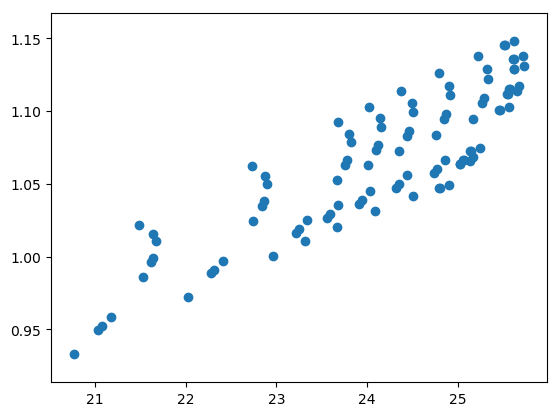

PyObject <matplotlib.collections.PathCollection object at 0x7f660805fe48>

In [62]:
PyPlot.scatter(ccc[:,1],ccc[:,2])

# Usando Box-Muller

In [ ]:
function energia_poinc_abs(x0, p0, m0, M0, a0, b0, H0)
    return (2. *M0*(H0-p0*p0/(2. *m0)+a*x0*x0/2. -b*x0*x0*x0*x0/4. ))^(1. /2. )
end
epsilon=0.01
m=[1.,0.1]
w=[0.,0.8]
g=[0.,0.1]
a=0.25
b=0.01
entmutua=[]
entsys=[]
entpozo=[]
entosci=[]
time=100.
dts=1//100
entropies=zeros(100)
Q1=[]
Q2=[]
P1=[]
P2=[]
tspan=(0., time)
k=0
sol3=0

m[2]=0.1
w[2]=0.7071
g[2]=0.05
dts=0.001*2. *pi/w[2]
Hsys(q,p) = p[1]^2. /(2. *m[1]) - a*q[1]^2. /2. +b*q[1]^4. /4. +q[1]*g[2]*q[2]+p[2]^2. /(2. *m[2])+m[2]*w[2]^2. *q[2]^2. /2. 
pdot(dp,p,q,params,t) = ForwardDiff.gradient!(dp, q->-Hsys(q, p), q)
qdot(dq,p,q,params,t) = ForwardDiff.gradient!(dq, p-> Hsys(q, p), p)
initial_position[2]=0.

@time for jj =1:arraysize
    #println(jj)
    #Hinicial=15.0
    initial_position[1]=xz0[jj]
    initial_momentum[1]=pz1[jj]
    initial_position[2]=Xz0[jj]
    initial_momentum[2]=Pz1[jj]
    
    prob = DynamicalODEProblem(pdot, qdot, initial_momentum, initial_position, tspan)
    sol3 = solve(prob, CalvoSanz4(), dt=dts);
    #@time sol3 = solve(prob, CalvoSanz4(), dt=dts);
    push!(Q1,sol3[3,1:10:end])
    push!(Q2,sol3[4,1:10:end])
    push!(P1,sol3[1,1:10:end])
    push!(P2,sol3[2,1:10:end])
    k=sol3
    

end
dim=length(Q2[1])
Q1=reduce(hcat,Q1)
Q2=reduce(hcat,Q2)
P1=reduce(hcat,P1)
P2=reduce(hcat,P2)
system=cat(Q1,Q2,P1,P2,dims=3)
pozo=cat(Q1,P1,dims=3)
oscilador=cat(Q2,P2,dims=3)
println(dim)
bbb=0
ccc=0

#draw()
@time for iiii in 1:dim
    num=lpad(iiii,8,"0")
    systemdata=Dataset(system[iiii,:,:])
    push!(entsys,genentropy(1, epsilon, systemdata;base=2.))
    pozodata=Dataset(pozo[iiii,:,:])
    if iiii==20
        bbb=pozodata
    end
    if iiii%5==0
        PyPlot.scatter(pozodata[:,1],pozodata[:,2], alpha=0.4, s=1.2)
        ylim(-8,8)
        xlim(-14,14)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del pozo")
        savefig("gifs/boxmuller/pozo$num.png")
        clf()
    end


    push!(entpozo,genentropy(1, epsilon, pozodata;base=2.))
    oscidata=Dataset(oscilador[iiii,:,:])
    if iiii==20
        ccc=oscidata
    end
    if iiii%5==0
        PyPlot.scatter(oscidata[:,1],oscidata[:,2], alpha=0.4, s=1.2)
        ylim(-4,4)
        xlim(-45,45)
        xlabel("x")
        ylabel("p")
        title("Espacio de fase del oscilador")
        savefig("gifs/boxmuller/osci$num.png")
        clf()
    end
    push!(entosci,genentropy(1, epsilon, oscidata;base=2.))
    push!(entmutua,entpozo[iiii]+entosci[iiii]-entsys[iiii])
end
#waitforbuttonpress()
#println(entsys)
#println(entpozo)
#println(entosci)
#println(entmutua)